# Stock trend classification (2.1/3): train MLP

Ref:
https://www.youtube.com/watch?v=KqBuSvEGiZA

### Load datasets

In [1]:
import numpy as np
import pandas as pd

CLASSES = ['Bull', 'Bear']
LABEL_BULL = CLASSES.index('Bull')
LABEL_BEAR = CLASSES.index('Bear')

datasets = np.load('datasets.npz')
x_train, y_train = datasets['x_train'], datasets['y_train']
x_val, y_val = datasets['x_val'], datasets['y_val']
x_test, y_test = datasets['x_test'], datasets['y_test']

# Label distribution
label_distribution = pd.DataFrame([{'Dataset': 'train',
                                    'Bull': np.count_nonzero(y_train == LABEL_BULL),
                                    'Bear': np.count_nonzero(y_train == LABEL_BEAR)},
                                   {'Dataset': 'val',
                                    'Bull': np.count_nonzero(y_val == LABEL_BULL),
                                    'Bear': np.count_nonzero(y_val == LABEL_BEAR)},
                                   {'Dataset': 'test',
                                    'Bull': np.count_nonzero(y_test == LABEL_BULL),
                                    'Bear': np.count_nonzero(y_test == LABEL_BEAR)}])
label_distribution

,Dataset,Bull,Bear
0,train,827,828
1,val,237,236
2,test,107,107


In [5]:
x_train.shape

(1655, 100, 5)

In [6]:
1655 * 100 * 5

827500

### Construct model

In [3]:
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model

# Build model
n_time_steps = x_train.shape[1]
n_features = x_train.shape[2]

input_layer = Input(shape=(n_time_steps, n_features))
x = Flatten()(input_layer)
x = Dense(256, activation='relu')(x)  # relu: Rectified Linear Unit
x = Dense(256, activation='relu')(x)
output_layer = Dense(len(CLASSES), activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 100, 5)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       128,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 194,562 (760.01 KB)

 Trainable params: 194,562 (760.01 KB)

 Non-trainable params: 0 (0.00 B)

### Train model

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_checkpoint = ModelCheckpoint(filepath='best_model.keras', monitor='val_loss',
                                   save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
callbacks = [model_checkpoint, early_stopping]

train_history = model.fit(x_train, to_categorical(y_train),
                          validation_data=(x_val, to_categorical(y_val)),
                          batch_size=2048, epochs=1000, callbacks=[callbacks])

Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step - accuracy: 0.5009 - loss: 10348238.0000 - val_accuracy: 0.5053 - val_loss: 7434957.0000
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4985 - loss: 7819196.5000 - val_accuracy: 0.5095 - val_loss: 5799888.0000
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4985 - loss: 6120809.5000 - val_accuracy: 0.4715 - val_loss: 1442404.3750
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5263 - loss: 1479599.3750 - val_accuracy: 0.5053 - val_loss: 4316903.0000
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5033 - loss: 4149365.2500 - val_accuracy: 0.5032 - val_loss: 4204640.5000
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5027 - loss: 4018219.0000 - val_accuracy: 0.5222 - val_loss: 1956166.2500
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5039 - loss: 1766378.3750 - val_accuracy: 0.5116 - val_loss: 1802273.5000
Epoch 8/1000
1/1 ━━━━━━━━

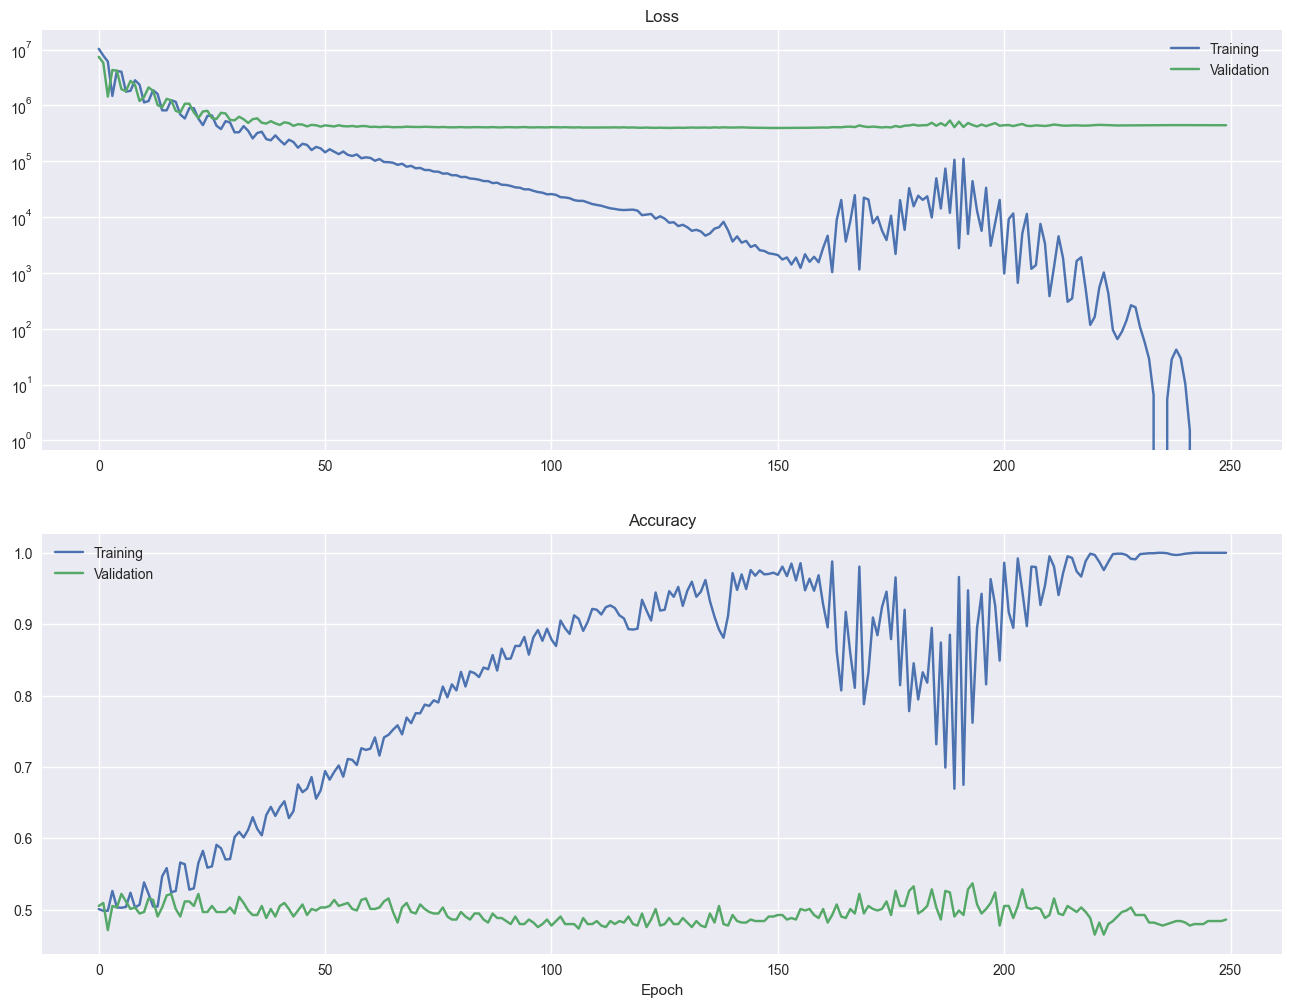

In [10]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

axes[0].set_title('Loss')
axes[0].set_yscale('log')
axes[0].plot(train_history.history['loss'], label='Training')
axes[0].plot(train_history.history['val_loss'], label='Validation')
axes[0].legend()

axes[1].set_title('Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].plot(train_history.history['accuracy'], label='Training')
axes[1].plot(train_history.history['val_accuracy'], label='Validation')
axes[1].legend()